In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests 
import time
import datetime as dt
from numpy import log
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARIMA

from pandas.tools.plotting import autocorrelation_plot

# statistical modeling libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.stats import boxcox
#from arch import arch_model


# remove warnings
import warnings
warnings.filterwarnings('ignore')


## plot config
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['text.usetex'] = False

%matplotlib inline

In [19]:
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return np.exp(np.log(lam * value + 1) / lam)

In [20]:
df = pd.read_csv('furtos_goiania.csv',index_col=0,parse_dates=True).sort_index()
df = df.loc[df.index >= '2013-01-01']
df = df.loc[df.index <= '2017-12-01']
df.drop('bairro', axis=1, inplace=True)
df.drop('mes', axis=1, inplace=True)
df.drop('ano', axis=1, inplace=True)
df.drop('tipo', axis=1, inplace=True)
df.sort_index()

,qtd
0,
2013-01-01,1141
2013-02-01,1122
2013-03-01,1212
2013-04-01,1265
2013-05-01,1376
2013-06-01,1436
2013-07-01,1116
2013-08-01,1150
2013-09-01,1148


In [21]:
def ts_diagnostics(y, lags=None, title='', filename=''):
    '''
    Calculate acf, pacf, qq plot and Augmented Dickey Fuller test for a given time series
    '''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    # weekly moving averages (12 months window because of years)
    rolling_mean = pd.rolling_mean(y, window=12)
    rolling_std = pd.rolling_std(y, window=12)
    
    fig = plt.figure(figsize=(14, 12))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    # time series plot
    y.plot(ax=ts_ax)
    rolling_mean.plot(ax=ts_ax, color='crimson');
    rolling_std.plot(ax=ts_ax, color='darkslateblue');
    plt.legend(loc='best')
    ts_ax.set_title(title, fontsize=24);
    
    # acf and pacf
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 
    
    # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')
    
    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25);
    hist_ax.set_title('Histogram');
    plt.tight_layout();
    
    #plot
    plt.show()
    
    # perform Augmented Dickey Fuller test
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

No handles with labels found to put in legend.


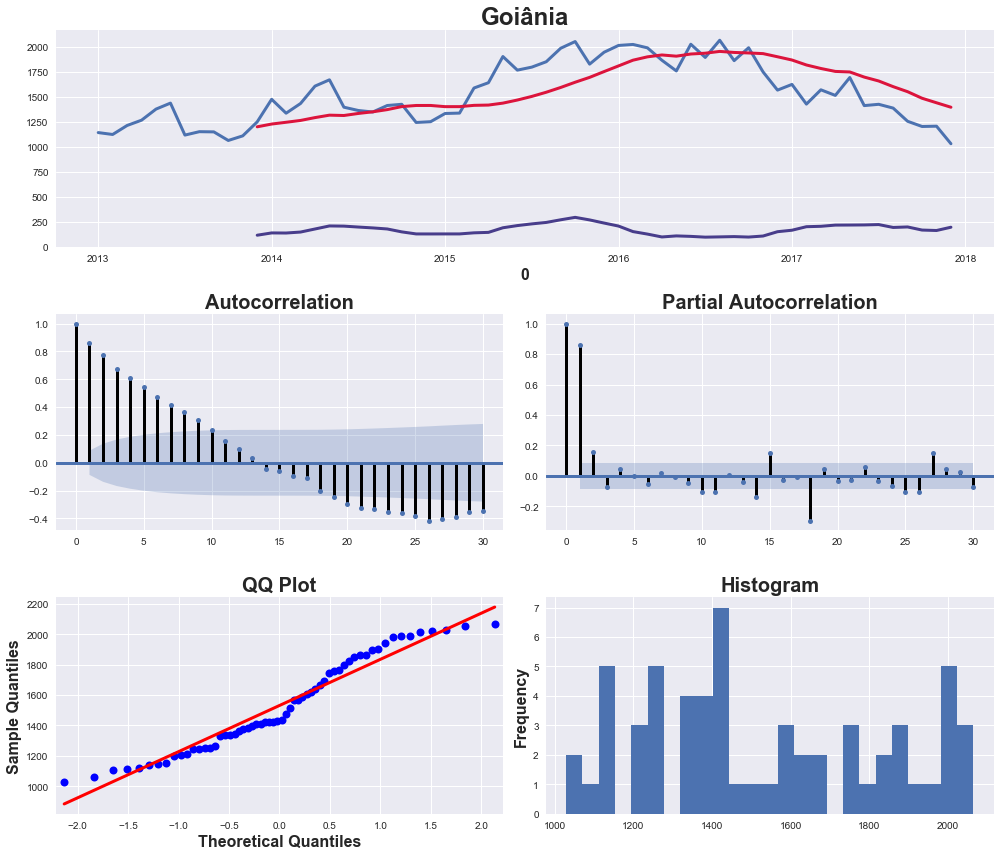

Results of Dickey-Fuller test:
test statistic          -1.349349
p-value                  0.606304
# of lags                1.000000
# of observations       58.000000
Critical Value (1%)     -3.548494
Critical Value (5%)     -2.912837
Critical Value (10%)    -2.594129
dtype: float64


In [22]:
ts_diagnostics(df['qtd'], lags=30, title='Goiânia')

No handles with labels found to put in legend.


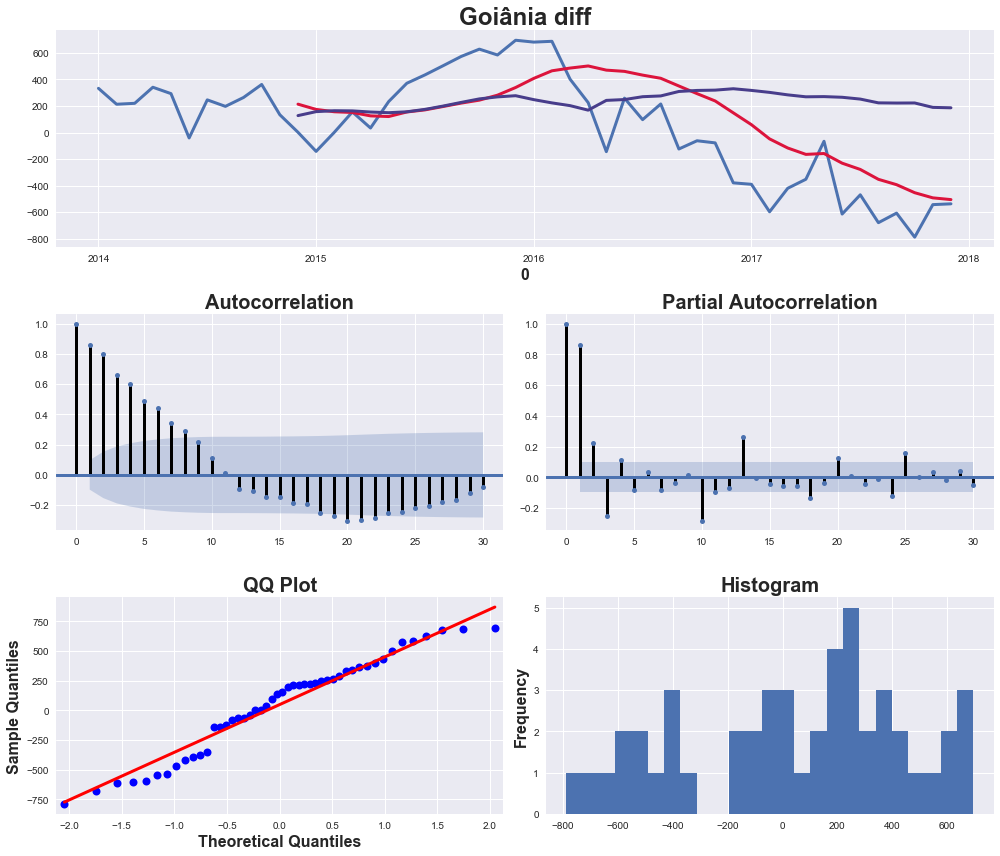

Results of Dickey-Fuller test:
test statistic          -0.719629
p-value                  0.841599
# of lags                3.000000
# of observations       44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
dtype: float64


In [23]:
y_diff = df['qtd'].diff(12).dropna()
ts_diagnostics(y_diff, lags=30, title='Goiânia diff', filename='adf_diff')

No handles with labels found to put in legend.


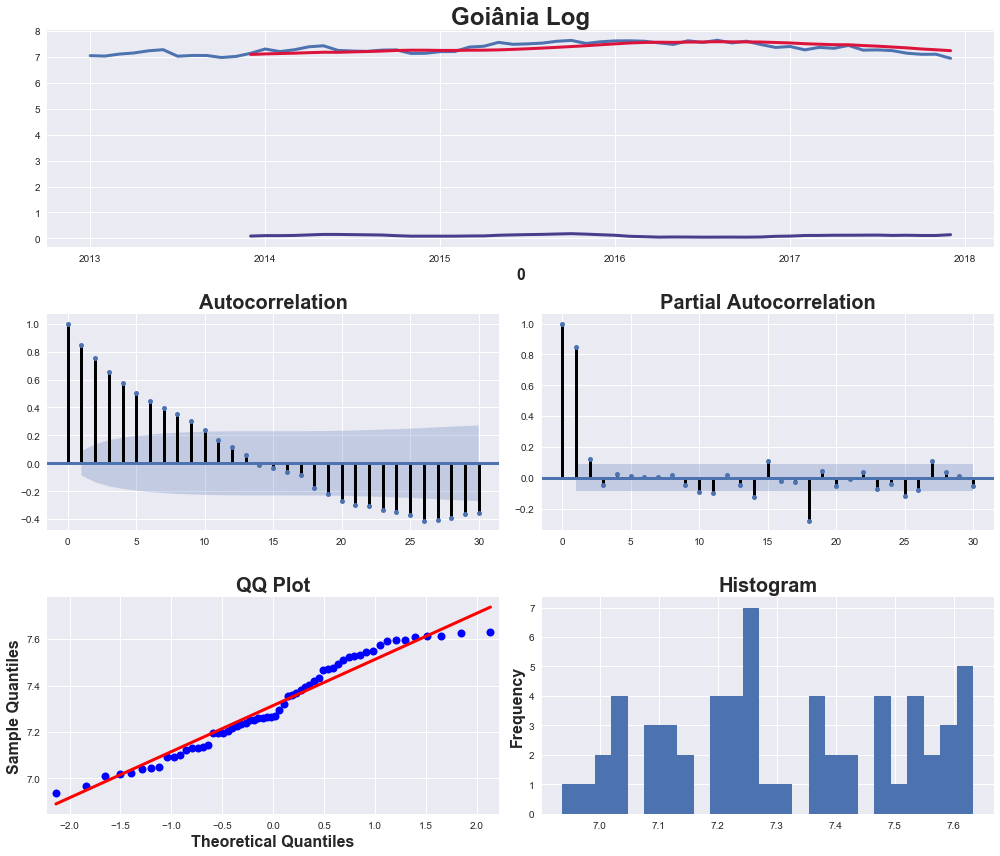

Results of Dickey-Fuller test:
test statistic          -1.574768
p-value                  0.496255
# of lags                0.000000
# of observations       59.000000
Critical Value (1%)     -3.546395
Critical Value (5%)     -2.911939
Critical Value (10%)    -2.593652
dtype: float64


In [24]:
y_log = np.log(df['qtd'])
ts_diagnostics(y_log, lags=30, title='Goiânia Log')

No handles with labels found to put in legend.


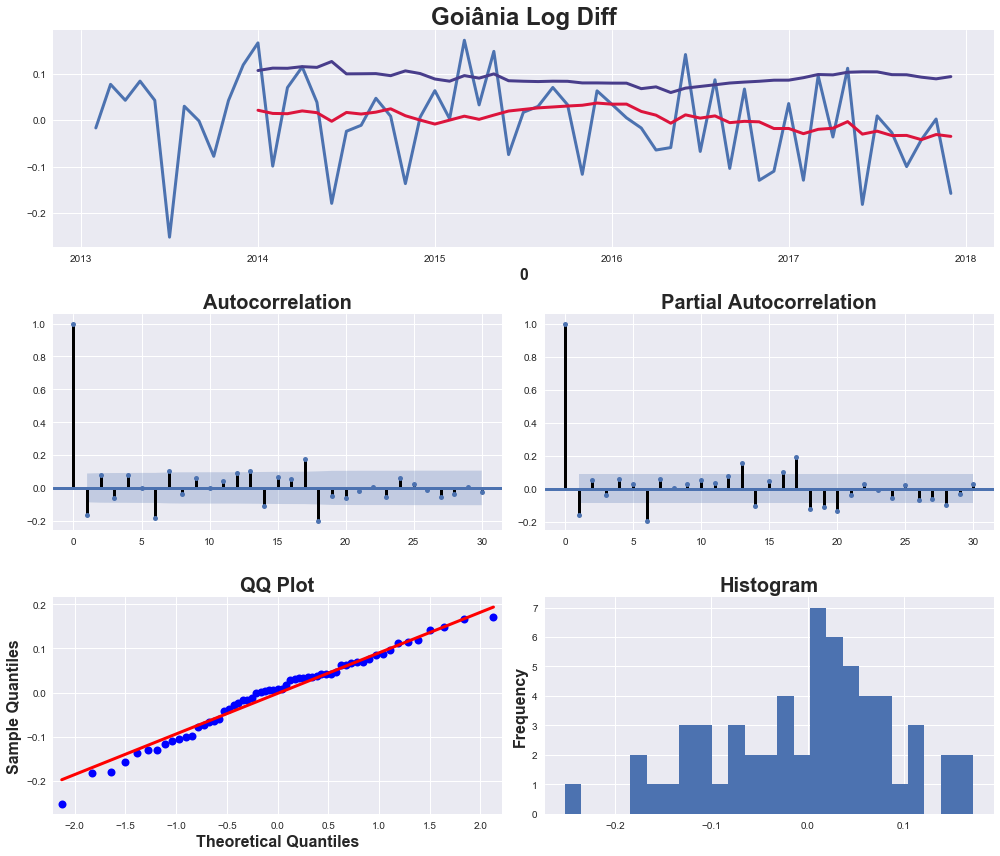

Results of Dickey-Fuller test:
test statistic         -8.668020e+00
p-value                 4.627361e-14
# of lags               0.000000e+00
# of observations       5.800000e+01
Critical Value (1%)    -3.548494e+00
Critical Value (5%)    -2.912837e+00
Critical Value (10%)   -2.594129e+00
dtype: float64


In [25]:
y_log_diff = np.log(df['qtd']).diff().dropna()
ts_diagnostics(y_log_diff, lags=30, title='Goiânia Log Diff')

No handles with labels found to put in legend.


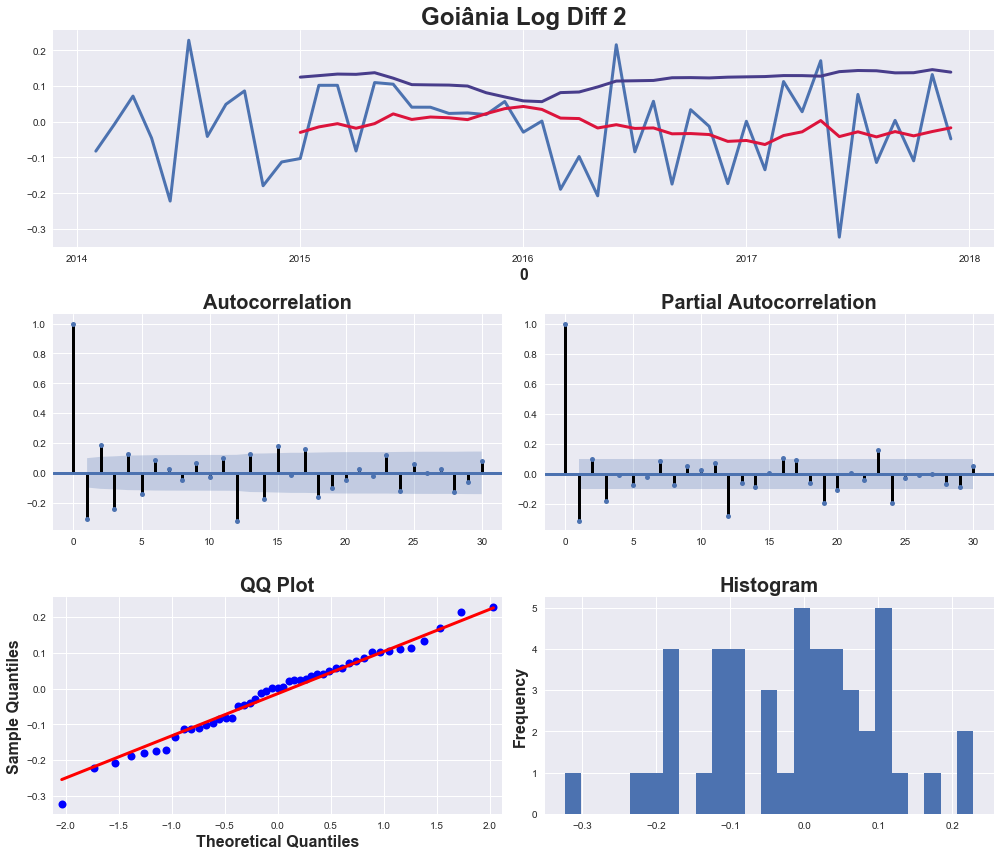

Results of Dickey-Fuller test:
test statistic          -4.450879
p-value                  0.000241
# of lags                2.000000
# of observations       44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
dtype: float64


In [26]:
y_log_diff2 = np.log(df['qtd']).diff().diff(12).dropna()
ts_diagnostics(y_log_diff2, lags=30, title='Goiânia Log Diff 2')

No handles with labels found to put in legend.


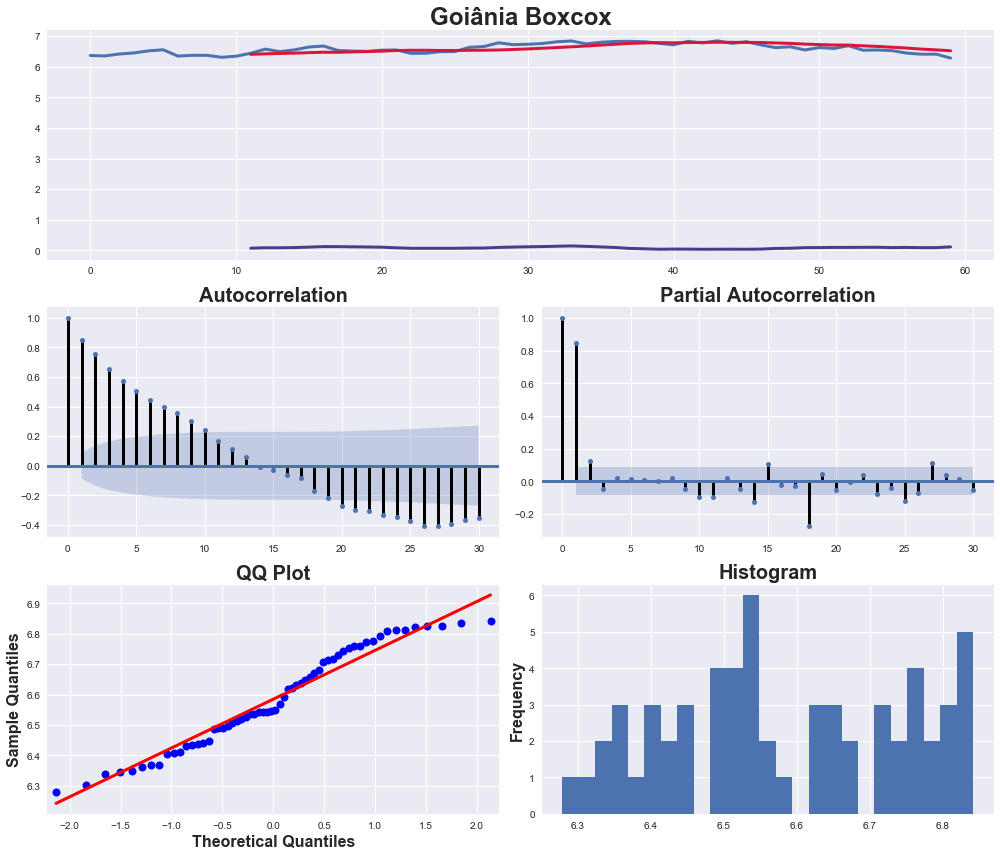

Results of Dickey-Fuller test:
test statistic          -1.572523
p-value                  0.497380
# of lags                0.000000
# of observations       59.000000
Critical Value (1%)     -3.546395
Critical Value (5%)     -2.911939
Critical Value (10%)    -2.593652
dtype: float64
-0.029217546836669432


In [27]:
X, lamP = boxcox(df['qtd'])
ts_diagnostics(X, lags=30, title='Goiânia Boxcox')
print(lamP)

## Valores sem conversão

predicted=1561.771535, expected=1623.000000
predicted=1585.854159, expected=1426.000000
predicted=1500.582923, expected=1569.000000
predicted=1560.911405, expected=1513.000000
predicted=1521.598143, expected=1692.000000
predicted=1605.430737, expected=1411.000000
predicted=1507.544658, expected=1424.000000
predicted=1366.698264, expected=1386.000000
predicted=1404.970202, expected=1254.000000
predicted=1307.814962, expected=1202.000000
predicted=1197.740845, expected=1205.000000
predicted=1184.131686, expected=1029.000000
Test MAE: 102.022
Test R2: 0.593
Test MSE: 14048.199
Test RMSE: 118.525


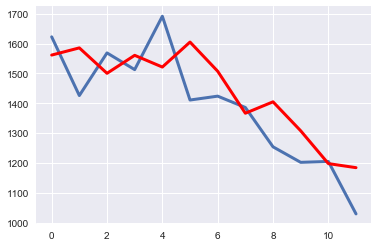

In [28]:
X = df['qtd'].values
size = int(len(X) * 0.80)
size
train, test = X[0:size], X[size:len(X)]
history = [x for x in train.astype(float)]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4, 1, 3))
    #3 0 4
    model_fit = model.fit(disp=1,transparams=False, solver='lbfgs', trend='nc')
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(test, predictions)
rms = sqrt(mean_squared_error(test, predictions))
coefficient_of_dermination = r2_score(test, predictions)
mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % coefficient_of_dermination)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % rms)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Valores com log

predicted=1624.731449, expected=1623.000000
predicted=1791.971377, expected=1426.000000
predicted=1479.625451, expected=1569.000000
predicted=1558.077502, expected=1513.000000
predicted=1622.958452, expected=1692.000000
predicted=1753.008894, expected=1411.000000
predicted=1536.136130, expected=1424.000000
predicted=1354.203493, expected=1386.000000
predicted=1355.503198, expected=1254.000000
predicted=1237.813464, expected=1202.000000
predicted=1180.360814, expected=1205.000000
predicted=1309.159171, expected=1029.000000
Test MAE: 124.938
Test R2: 0.224
Test MSE: 30830.162
Test RMSE: 175.585


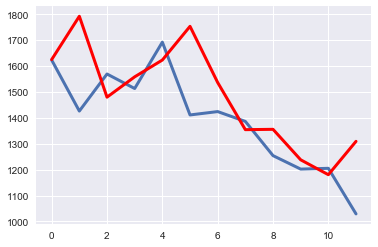

In [29]:
X = y_log.values
size = int(len(X) * 0.80)
size
train, test = X[0:size], X[size:len(X)]
history = [x for x in train.astype(float)]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(9, 1, 9), freq = 'M')
    # 3 1 2
    model_fit = model.fit(disp=0, transparams=False)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

error = mean_squared_error(np.exp(test), np.exp(predictions))
rms = sqrt(mean_squared_error(np.exp(test),np.exp(predictions)))
coefficient_of_dermination = r2_score(test, predictions)
mae = mean_absolute_error(np.exp(test), np.exp(predictions))
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % coefficient_of_dermination)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % rms)
# plot
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

## Valores com BoxCox

>Predicted=1795.692, Expected=1623.000
>Predicted=1898.527, Expected=1426.000
>Predicted=1519.422, Expected=1569.000
>Predicted=1627.720, Expected=1513.000
>Predicted=1556.934, Expected=1692.000
>Predicted=1551.965, Expected=1411.000
>Predicted=1441.029, Expected=1424.000
>Predicted=1479.476, Expected=1386.000
>Predicted=1425.905, Expected=1254.000
>Predicted=1195.083, Expected=1202.000
>Predicted=1159.772, Expected=1205.000
>Predicted=1096.549, Expected=1029.000
LAM: -0.029
Test MAE: 123.971
Test R2: 0.149
Test MSE: 30830.162
RMSE: 171.287


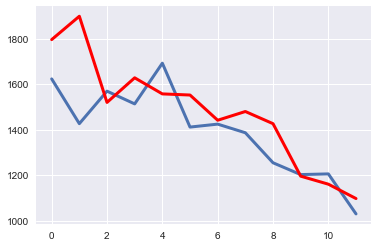

In [30]:
X = df['qtd'].values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

# walk-foward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# transform
	transformed, lam = boxcox(history)
	if lam < -5:
		transformed, lam = history, 1
	# predict
	model = ARIMA(transformed, order=(11, 1, 6))
	#3 1 3
	model_fit = model.fit(disp=0, transparams=False)
	yhat = model_fit.forecast()[0]
	# invert transformed prediction
	yhat = boxcox_inverse(yhat, lam)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
mse = mean_squared_error(np.float64(test),np.float64(predictions))
rmse = sqrt(mse)
mae = mean_absolute_error(np.float64(test),np.float64(predictions))
coefficient_of_dermination = r2_score(test, predictions)
print('LAM: %.3f' % lamP)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % coefficient_of_dermination)
print('Test MSE: %.3f' % error)
print('RMSE: %.3f' % rmse)
plt.plot(np.float64(test))
plt.plot(np.float64(predictions), color='red')
plt.show()

## Valores com diff

In [31]:
# values_diff = df[].dropna().values
X = y_diff.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train.astype(float)]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4, 0, 3))
    model_fit = model.fit(disp=0, transparams=True)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rms = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)
coefficient_of_dermination = r2_score(test, predictions)
print('Test R2: %.3f' % coefficient_of_dermination)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % rms)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=nan, expected=-420.000000
predicted=nan, expected=-352.000000
predicted=nan, expected=-66.000000
predicted=nan, expected=-614.000000


LinAlgError: SVD did not converge

## Valores log diff

In [32]:
# values_diff = df[].dropna().values
X = y_log_diff2.astype('float64')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train.astype(float)]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4, 0, 4))
    model_fit = model.fit(disp=0, transparams=True)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rms = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)
coefficient_of_dermination = r2_score(test, predictions)
print('Test R2: %.3f' % coefficient_of_dermination)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % rms)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=nan, expected=0.112515
predicted=-0.039904, expected=0.028027
predicted=0.035373, expected=0.170901
predicted=-0.012345, expected=-0.323005
predicted=0.066211, expected=0.076578
predicted=-0.056816, expected=-0.114015
predicted=0.122495, expected=0.003933
predicted=-0.063734, expected=-0.109372
predicted=0.049000, expected=0.132155
predicted=-0.020315, expected=-0.047944


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from numpy import mean
X = df['qtd'].values
window = 2
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions)) 

print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
# zoom plot
# plt.plot(test[:100])
# plt.plot(predictions[:100], color='red')
# plt.show()

## Analizar order Arima

In [41]:
def evaluate_arima_model(X, arima_order):
	X = X.astype('float32')
	train_size = int(len(X) * 0.80)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
        
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0,solver='lbfgs', trend='c',transparams=False)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset

# evaluate parameters
p_values = range(0,6)
d_values = range(0, 3)
q_values = range(0, 6)
warnings.filterwarnings("ignore")

In [88]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model_boxcox(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.85)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		transformed, lam = boxcox(history)
		if lam < -5:
			transformed, lam = history, 1
		model = ARIMA(transformed, order=arima_order)
		model_fit = model.fit(disp=0,transparams=False)
		yhat = model_fit.forecast()[0]
		yhat = boxcox_inverse(yhat, lam)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models_boxcox(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model_boxcox(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [42]:
evaluate_models(df['qtd'].values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=242.674
ARIMA(0, 0, 1) MSE=230.051
ARIMA(0, 0, 2) MSE=173.653
ARIMA(0, 0, 3) MSE=191.927
ARIMA(0, 0, 4) MSE=139.102
ARIMA(0, 0, 5) MSE=149.934
ARIMA(0, 1, 0) MSE=140.684
ARIMA(0, 1, 1) MSE=134.215
ARIMA(0, 1, 2) MSE=133.150
ARIMA(0, 1, 3) MSE=151.156
ARIMA(0, 1, 4) MSE=144.194
ARIMA(0, 1, 5) MSE=140.881
ARIMA(0, 2, 0) MSE=240.979
ARIMA(0, 2, 1) MSE=133.572
ARIMA(1, 0, 0) MSE=199.005
ARIMA(1, 0, 1) MSE=214.261
ARIMA(1, 0, 2) MSE=206.115
ARIMA(1, 0, 3) MSE=233.168
ARIMA(1, 0, 4) MSE=190.822
ARIMA(1, 0, 5) MSE=198.859
ARIMA(1, 1, 0) MSE=135.175
ARIMA(1, 1, 1) MSE=130.821
ARIMA(1, 2, 0) MSE=191.261
ARIMA(1, 2, 1) MSE=118.511
ARIMA(1, 2, 2) MSE=144.248
ARIMA(1, 2, 3) MSE=151.419
ARIMA(1, 2, 4) MSE=182.224
ARIMA(2, 0, 0) MSE=212.177
ARIMA(2, 0, 1) MSE=194.454
ARIMA(2, 0, 2) MSE=189.639
ARIMA(2, 0, 3) MSE=214.436
ARIMA(2, 0, 4) MSE=191.012
ARIMA(2, 0, 5) MSE=155.997
ARIMA(2, 1, 0) MSE=133.963
ARIMA(2, 1, 1) MSE=4211196724842553344.000
ARIMA(2, 2, 0) MSE=179.601
ARIMA(2, 2, 

In [90]:
evaluate_models_boxcox(df['qtd'].values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=255.950
ARIMA(0, 0, 1) MSE=271.184
ARIMA(0, 0, 2) MSE=168.418
ARIMA(0, 0, 3) MSE=173.994
ARIMA(0, 0, 4) MSE=135.404
ARIMA(0, 0, 5) MSE=141.112
ARIMA(0, 0, 6) MSE=153.301
ARIMA(0, 0, 7) MSE=175.657
ARIMA(0, 1, 0) MSE=139.152
ARIMA(0, 1, 1) MSE=134.375
ARIMA(0, 1, 2) MSE=133.063
ARIMA(0, 1, 3) MSE=138.015
ARIMA(0, 1, 4) MSE=131.323
ARIMA(0, 1, 5) MSE=129.619
ARIMA(0, 1, 6) MSE=168.274
ARIMA(0, 1, 7) MSE=170.460
ARIMA(0, 1, 8) MSE=161.949
ARIMA(0, 1, 9) MSE=169.119
ARIMA(0, 1, 11) MSE=148.997
ARIMA(0, 2, 0) MSE=223.244
ARIMA(0, 2, 1) MSE=128.681
ARIMA(1, 0, 0) MSE=204.441
ARIMA(1, 0, 1) MSE=216.593
ARIMA(1, 0, 2) MSE=209.424
ARIMA(1, 0, 3) MSE=198.304
ARIMA(1, 0, 4) MSE=163.056
ARIMA(1, 0, 5) MSE=177.400
ARIMA(1, 0, 6) MSE=192.640
ARIMA(1, 0, 7) MSE=196.786
ARIMA(1, 0, 8) MSE=126.575
ARIMA(1, 0, 9) MSE=154.620
ARIMA(1, 0, 10) MSE=185.317
ARIMA(1, 1, 0) MSE=135.397
ARIMA(1, 1, 1) MSE=128.302
ARIMA(1, 2, 0) MSE=172.367
ARIMA(1, 2, 1) MSE=118.058
ARIMA(1, 2, 2) MSE=187.505

In [91]:
evaluate_models(values_diff, p_values, d_values, q_values)

ARIMA(0, 0, 1) MSE=130.813
ARIMA(0, 0, 2) MSE=129.266
ARIMA(0, 0, 3) MSE=137.808
ARIMA(0, 0, 4) MSE=137.384
ARIMA(0, 0, 5) MSE=132.625
ARIMA(0, 0, 6) MSE=146.363
ARIMA(0, 0, 7) MSE=144.449
ARIMA(0, 0, 8) MSE=147.562
ARIMA(0, 0, 9) MSE=125.079
ARIMA(0, 0, 10) MSE=137.160
ARIMA(0, 0, 11) MSE=133.958
ARIMA(0, 1, 1) MSE=138.820
ARIMA(0, 2, 1) MSE=237.392
ARIMA(1, 0, 0) MSE=132.378
ARIMA(1, 0, 1) MSE=128.067
ARIMA(1, 1, 0) MSE=189.606
ARIMA(1, 1, 1) MSE=125.926
ARIMA(1, 1, 2) MSE=172.517
ARIMA(1, 1, 3) MSE=170.937
ARIMA(1, 1, 4) MSE=135.369
ARIMA(1, 2, 0) MSE=327.148
ARIMA(2, 0, 0) MSE=131.711
ARIMA(2, 0, 1) MSE=316848323207620.812
ARIMA(2, 1, 0) MSE=178.030
ARIMA(2, 1, 1) MSE=125.704
ARIMA(2, 1, 3) MSE=198.069
ARIMA(2, 2, 0) MSE=281.542
ARIMA(2, 2, 4) MSE=280.601
ARIMA(3, 0, 0) MSE=134.586
ARIMA(3, 0, 1) MSE=133.749
ARIMA(3, 0, 2) MSE=133.546
ARIMA(3, 0, 3) MSE=139.218
ARIMA(3, 1, 0) MSE=500857683890.411
ARIMA(3, 1, 1) MSE=158.336
ARIMA(3, 2, 0) MSE=247.723
ARIMA(3, 2, 1) MSE=242.205
ARIMA

In [92]:
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 1) MSE=3.563
ARIMA(0, 0, 2) MSE=1.948
ARIMA(0, 0, 3) MSE=0.952
ARIMA(0, 0, 4) MSE=0.918
ARIMA(0, 0, 5) MSE=0.339
ARIMA(0, 0, 6) MSE=1.420
ARIMA(0, 0, 7) MSE=0.309
ARIMA(0, 1, 1) MSE=0.093
ARIMA(0, 1, 2) MSE=0.093
ARIMA(0, 1, 3) MSE=0.098
ARIMA(0, 1, 4) MSE=0.098
ARIMA(0, 1, 5) MSE=0.095
ARIMA(0, 1, 6) MSE=0.104
ARIMA(0, 1, 7) MSE=0.101
ARIMA(0, 1, 8) MSE=0.103
ARIMA(0, 2, 1) MSE=0.096
ARIMA(1, 0, 0) MSE=3.873
ARIMA(1, 1, 0) MSE=0.094
ARIMA(1, 1, 1) MSE=0.094
ARIMA(1, 2, 0) MSE=0.128
ARIMA(1, 2, 1) MSE=0.091
ARIMA(2, 0, 0) MSE=3.993
ARIMA(2, 1, 0) MSE=0.094
ARIMA(2, 1, 1) MSE=22313036449.989
ARIMA(2, 2, 0) MSE=0.121
ARIMA(2, 2, 1) MSE=0.092
ARIMA(3, 0, 0) MSE=5251063811.204
ARIMA(3, 1, 0) MSE=0.095
ARIMA(3, 1, 1) MSE=0.094
ARIMA(3, 1, 2) MSE=0.088
ARIMA(3, 1, 3) MSE=0.094
ARIMA(3, 2, 0) MSE=0.114
ARIMA(3, 2, 1) MSE=0.094
ARIMA(4, 0, 0) MSE=3.984
ARIMA(4, 1, 0) MSE=0.096
ARIMA(4, 1, 1) MSE=0.096
ARIMA(4, 1, 2) MSE=11578499976274370269720882074378410393600.000
ARIMA(4, 1, 3) M

In [94]:
evaluate_models(y_log_diff, p_values, d_values, q_values)

ARIMA(0, 0, 1) MSE=0.093
ARIMA(0, 0, 2) MSE=0.093
ARIMA(0, 0, 3) MSE=0.098
ARIMA(0, 0, 4) MSE=0.098
ARIMA(0, 0, 5) MSE=0.095
ARIMA(0, 0, 6) MSE=0.104
ARIMA(0, 0, 7) MSE=0.101
ARIMA(0, 0, 8) MSE=0.103
ARIMA(0, 1, 1) MSE=0.096
ARIMA(0, 2, 1) MSE=0.157
ARIMA(1, 0, 0) MSE=0.094
ARIMA(1, 0, 1) MSE=0.094
ARIMA(1, 1, 0) MSE=0.128
ARIMA(1, 1, 1) MSE=0.091
ARIMA(1, 2, 0) MSE=0.217
ARIMA(1, 2, 4) MSE=0.084
ARIMA(2, 0, 0) MSE=0.094
ARIMA(2, 0, 1) MSE=0.096
ARIMA(2, 1, 0) MSE=0.121
ARIMA(2, 1, 1) MSE=0.092
ARIMA(2, 2, 0) MSE=0.190
ARIMA(2, 2, 1) MSE=0.145
ARIMA(2, 2, 2) MSE=0.084
ARIMA(2, 2, 4) MSE=0.277
ARIMA(3, 0, 0) MSE=0.095
ARIMA(3, 0, 1) MSE=0.094
ARIMA(3, 0, 2) MSE=0.084
ARIMA(3, 0, 3) MSE=0.098
ARIMA(3, 1, 0) MSE=0.114
ARIMA(3, 1, 1) MSE=0.094
ARIMA(3, 2, 0) MSE=33935330.591
ARIMA(3, 2, 1) MSE=0.161
ARIMA(3, 2, 2) MSE=0.086
ARIMA(3, 2, 4) MSE=0.111
ARIMA(4, 0, 0) MSE=0.096
ARIMA(4, 0, 1) MSE=0.096
ARIMA(4, 0, 2) MSE=0.088
ARIMA(4, 0, 3) MSE=0.087
ARIMA(4, 0, 4) MSE=0.076
ARIMA(4, 1, 0) MSE

In [95]:
evaluate_models(y_log_diff2, p_values, d_values, q_values)

ARIMA(0, 0, 1) MSE=0.130
ARIMA(0, 0, 2) MSE=0.131
ARIMA(0, 0, 3) MSE=0.124
ARIMA(0, 0, 4) MSE=0.125
ARIMA(0, 0, 5) MSE=0.125
ARIMA(0, 0, 6) MSE=0.129
ARIMA(0, 0, 7) MSE=0.133
ARIMA(0, 0, 8) MSE=0.135
ARIMA(0, 0, 9) MSE=0.173
ARIMA(0, 0, 10) MSE=0.183
ARIMA(0, 0, 11) MSE=0.184
ARIMA(0, 1, 1) MSE=0.140
ARIMA(0, 2, 1) MSE=0.252
ARIMA(1, 0, 0) MSE=0.132
ARIMA(1, 0, 1) MSE=0.131
ARIMA(1, 1, 0) MSE=0.194
ARIMA(1, 1, 1) MSE=0.127
ARIMA(1, 1, 2) MSE=0.123
ARIMA(1, 2, 0) MSE=0.327
ARIMA(1, 2, 1) MSE=0.266
ARIMA(2, 0, 0) MSE=0.132
ARIMA(2, 0, 1) MSE=0.132
ARIMA(2, 0, 2) MSE=0.118
ARIMA(2, 1, 0) MSE=0.192
ARIMA(2, 1, 2) MSE=0.190
ARIMA(2, 2, 0) MSE=0.305
ARIMA(3, 0, 0) MSE=0.129
ARIMA(3, 0, 1) MSE=0.129
ARIMA(3, 0, 2) MSE=25784801255612088.000
ARIMA(3, 0, 3) MSE=0.142
ARIMA(3, 1, 0) MSE=0.178
ARIMA(3, 1, 1) MSE=0.148
ARIMA(3, 2, 0) MSE=1324771101.205
ARIMA(4, 0, 0) MSE=0.130
ARIMA(4, 0, 1) MSE=0.110
ARIMA(4, 0, 2) MSE=0.131
ARIMA(4, 0, 3) MSE=0.120
ARIMA(4, 0, 4) MSE=0.136
ARIMA(4, 1, 0) MSE=0.17

In [46]:
X = df['qtd'].values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=1363.166667, mean2=1699.466667
variance1=41787.005556, variance2=85640.115556


In [54]:
from pandas import Series

series = Series.from_csv('furtos_goiania_clean.csv', header=0)
X = series[:'2018-12-01'].values
X = X.astype('float32')

model = ARIMA(X, order=(3, 0, 4))
model.dates = None
model.freq = 'c'
model.missing = None
model_fit = model.fit(disp=0, transparams=False, start_ar_lags=13)
model_fit.save('model.pkl')

In [55]:
from statsmodels.tsa.arima_model import ARIMAResults
loaded = ARIMAResults.load('model.pkl')

In [56]:
print(loaded.forecast(steps=12)[0])

[1144.1673056  1194.18964457 1295.77688311 1348.11666476 1380.0530274
 1425.17718101 1446.31406003 1463.65722749 1483.07319096 1492.15120275
 1501.05188559 1509.26066969]


In [57]:
size = len(X)
print(size)
forecast = loaded.predict(start=size, end=size+11)
print(forecast)

60
[1144.1673056  1194.18964457 1295.77688311 1348.11666476 1380.0530274
 1425.17718101 1446.31406003 1463.65722749 1483.07319096 1492.15120275
 1501.05188559 1509.26066969]


In [58]:
from pandas import Series
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

In [59]:
series = Series.from_csv('furtos_goiania_clean.csv', header=0)
X = difference(series)

ADF Statistic: -9.341867
p-value: 0.000000
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


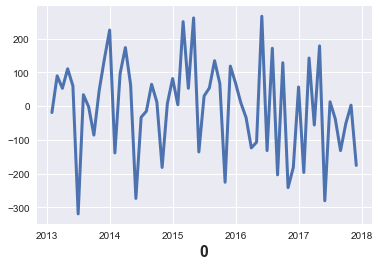

In [60]:
X = series.values
X = X.astype('float32')
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
plt.show()

In [93]:
evaluate_models(stationary, p_values, d_values, q_values)

ARIMA(0, 0, 1) MSE=130.813
ARIMA(0, 0, 2) MSE=129.266
ARIMA(0, 0, 3) MSE=137.808
ARIMA(0, 0, 4) MSE=137.384
ARIMA(0, 0, 5) MSE=132.625
ARIMA(0, 0, 6) MSE=146.363
ARIMA(0, 0, 7) MSE=144.449
ARIMA(0, 0, 8) MSE=147.562
ARIMA(0, 0, 9) MSE=125.079
ARIMA(0, 0, 10) MSE=137.160
ARIMA(0, 0, 11) MSE=133.958
ARIMA(0, 1, 1) MSE=138.820
ARIMA(0, 2, 1) MSE=237.392
ARIMA(1, 0, 0) MSE=132.378
ARIMA(1, 0, 1) MSE=128.067
ARIMA(1, 1, 0) MSE=189.606
ARIMA(1, 1, 1) MSE=125.926
ARIMA(1, 1, 2) MSE=172.517
ARIMA(1, 1, 3) MSE=170.937
ARIMA(1, 1, 4) MSE=135.369
ARIMA(1, 2, 0) MSE=327.148
ARIMA(2, 0, 0) MSE=131.711
ARIMA(2, 0, 1) MSE=316848323207620.812
ARIMA(2, 1, 0) MSE=178.030
ARIMA(2, 1, 1) MSE=125.704
ARIMA(2, 1, 3) MSE=198.069
ARIMA(2, 2, 0) MSE=281.542
ARIMA(2, 2, 4) MSE=280.601
ARIMA(3, 0, 0) MSE=134.586
ARIMA(3, 0, 1) MSE=133.749
ARIMA(3, 0, 2) MSE=133.546
ARIMA(3, 0, 3) MSE=139.218
ARIMA(3, 1, 0) MSE=500857683890.411
ARIMA(3, 1, 1) MSE=158.336
ARIMA(3, 2, 0) MSE=247.723
ARIMA(3, 2, 1) MSE=242.205
ARIMA

predicted=-6.135887, expected=57.000000
predicted=-9.492102, expected=-197.000000
predicted=70.283897, expected=143.000000
predicted=-20.767091, expected=-56.000000
predicted=16.974574, expected=179.000000
predicted=-14.252862, expected=-281.000000
predicted=82.771359, expected=13.000000
predicted=-32.607248, expected=-38.000000
predicted=-5.195403, expected=-132.000000
predicted=56.726714, expected=-52.000000
predicted=-3.277423, expected=3.000000
predicted=-14.031909, expected=-176.000000
Test R2: 0.016
Test MSE: 16845.976
Test RMSE: 129.792


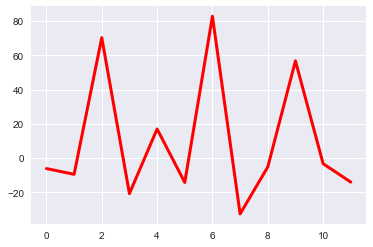

In [65]:
X = stationary
size = int(len(X) * 0.80)
size
train, test = X[0:size], X[size:len(X)]
history = [x for x in train.astype(float)]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4, 0, 3))
    #3 0 4
    model_fit = model.fit(disp=0,transparams=False)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(test, predictions)
rms = sqrt(mean_squared_error(test, predictions))
coefficient_of_dermination = r2_score(test, predictions)
print('Test R2: %.3f' % coefficient_of_dermination)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % rms)
# plot
# plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [66]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

ValueError: view limit minimum -36833.200000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 432x288 with 1 Axes>

In [92]:
model = ARIMA(history, order=(5, 0, 2))
model_fit = model.fit(disp=0,transparams=False)
print(model_fit.forecast()[0])

[-130.79525425]


In [ ]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return diff

teste_dif = np.float64(difference(df['qtd'].values))

Solver=lbfgs, Test RMSE: 129.792, Time=6.633429
Solver=bfgs, Test RMSE: 133.252, Time=8.599353
Solver=newton, Test RMSE: 133.252, Time=8.599353
Solver=nm, Test RMSE: 145.344, Time=6.360635
Solver=cg, Test RMSE: 132.882, Time=9.778113
Solver=ncg, Test RMSE: 150.828, Time=33.894900
Solver=powell, Test RMSE: 12813289.844, Time=46.711029


ValueError: shape mismatch: objects cannot be broadcast to a single shape

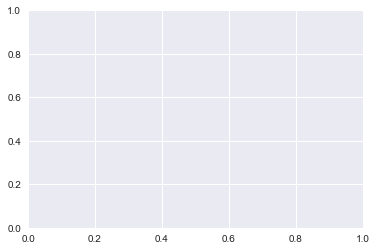

In [27]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import time

# split into train and test sets
X = np.float64(df['qtd'].values)
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
# solvers
solvers = ['lbfgs', 'bfgs', 'newton', 'nm', 'cg', 'ncg', 'powell']
scores = []
times = []
for solver in solvers:
    try:
        start_time = time()
        history = [x for x in train]
        predictions = list()
        # walk-forward validation
        for t in range(len(test)):
            # fit model
            model = ARIMA(history, order=(4, 1, 3))
            model_fit = model.fit(disp=False, solver=solver, transparams=False)
            # one step forecast
            yhat = model_fit.forecast()[0]
            # store forecast and ob
            predictions.append(yhat)
            history.append(test[t])
        # evaluate forecasts
        rmse = sqrt(mean_squared_error(test, predictions))
        timing = time() - start_time
        scores.append(rmse)
        times.append(timing)
    except:
        pass
    print('Solver=%s, Test RMSE: %.3f, Time=%f' % (solver, rmse, timing))
# plot scores
ticks = [i for i in range(len(solvers))]
pyplot.bar(ticks, scores)
pyplot.xticks(ticks, solvers)
pyplot.show()
# plot times
ticks = [i for i in range(len(solvers))]
pyplot.bar(ticks, times)
pyplot.xticks(ticks, solvers)
pyplot.show()